In [12]:
!pip install numpy pandas scikit-learn tensorflow matplotlib seaborn tqdm joblib


In [14]:
pip install seaborn==0.12.2 matplotlib==3.7.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires num

In [14]:
# ============================================================
# 🧠 FinBERT + LSTM for Sentiment Classification (Full Evaluation)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    average_precision_score, classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)
import joblib


In [16]:
# ============================================================
# 1️⃣ Load FinBERT Embeddings + Sentiment Labels
# ============================================================
emb_path = "finbert_output/finbert_embeddings.npz"
sent_path = "finbert_output/finbert_sentences.csv"

X = np.load(emb_path)["embeddings"]
df = pd.read_csv(sent_path)

df.columns = ["label", "sentence"]
df["label"] = df["label"].astype(str).str.strip().str.lower()

label_map = {"negative": 0, "neutral": 1, "positive": 2}
df = df[df["label"].isin(label_map.keys())]
y = df["label"].map(label_map).values
X = X[:len(y)]

print(f"✅ Loaded {len(y)} samples | Embeddings shape: {X.shape}")

✅ Loaded 4846 samples | Embeddings shape: (4846, 768)


In [17]:
# ============================================================
# 2️⃣ Encode + Split
# ============================================================
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("LSTM input shape:", X_train.shape)

LSTM input shape: (3876, 1, 768)


In [18]:
# ============================================================
# 3️⃣ Build LSTM Model
# ============================================================
model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(1, X.shape[1])),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,227 (1.79 MB)

 Trainable params: 467,971 (1.79 MB)

 Non-trainable params: 256 (1.00 KB)

In [19]:
# ============================================================
# 4️⃣ Train Model
# ============================================================
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=25,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Epoch 1/25
109/109 - 5s - 45ms/step - accuracy: 0.8773 - loss: 0.3896 - val_accuracy: 0.8943 - val_loss: 0.2969
Epoch 2/25
109/109 - 1s - 10ms/step - accuracy: 0.8982 - loss: 0.2910 - val_accuracy: 0.8892 - val_loss: 0.2609
Epoch 3/25
109/109 - 1s - 10ms/step - accuracy: 0.9005 - loss: 0.2922 - val_accuracy: 0.9072 - val_loss: 0.2572
Epoch 4/25
109/109 - 1s - 12ms/step - accuracy: 0.9040 - loss: 0.2756 - val_accuracy: 0.9098 - val_loss: 0.2413
Epoch 5/25
109/109 - 1s - 10ms/step - accuracy: 0.9048 - loss: 0.2643 - val_accuracy: 0.9072 - val_loss: 0.2426
Epoch 6/25
109/109 - 2s - 16ms/step - accuracy: 0.9074 - loss: 0.2586 - val_accuracy: 0.9046 - val_loss: 0.2589
Epoch 7/25
109/109 - 3s - 24ms/step - accuracy: 0.9085 - loss: 0.2494 - val_accuracy: 0.8943 - val_loss: 0.2456
Epoch 8/25
109/109 - 2s - 21ms/step - accuracy: 0.9100 - loss: 0.2287 - val_accuracy: 0.9098 - val_loss: 0.2527
Epoch 9/25
109/109 - 1s - 10ms/step - accuracy: 0.9097 - loss: 0.2298 - val_accuracy: 0.9175 - val_loss:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📊 Model Performance:
Accuracy: 0.8938
F1 Score (weighted): 0.8943

📈 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       121
           1       0.93      0.90      0.91       576
           2       0.85      0.88      0.86       273

    accuracy                           0.89       970
   macro avg       0.87      0.89      0.88       970
weighted avg       0.90      0.89      0.89       970



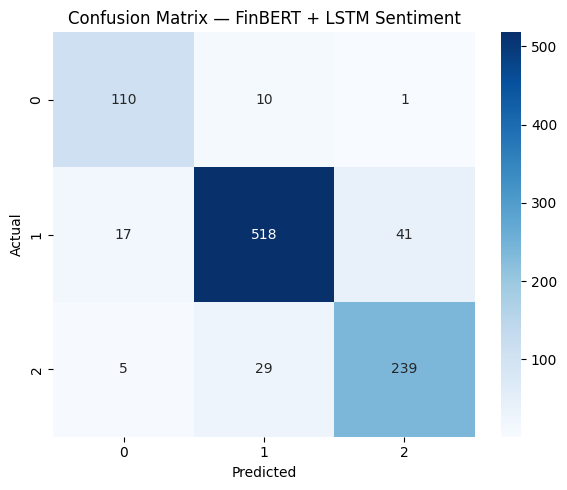

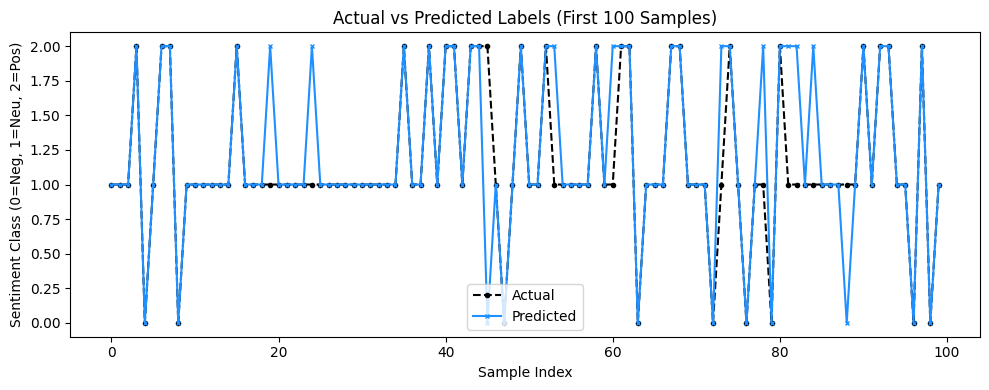

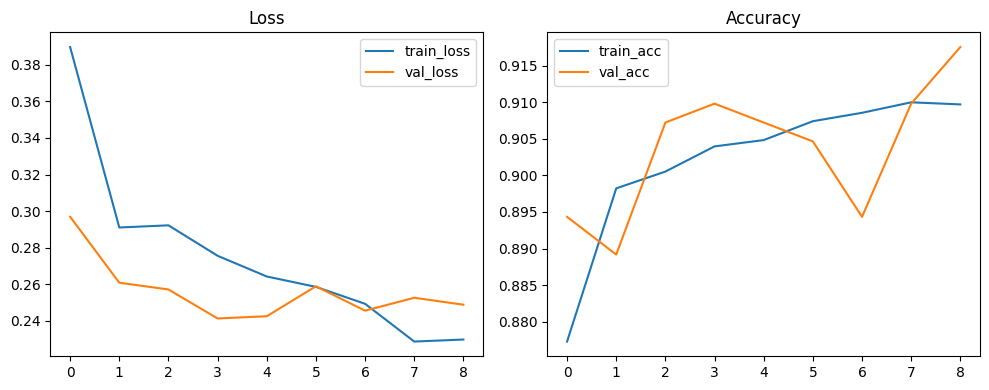


✅ Saved model → 'finbert_lstm_sentiment_final.h5'
✅ Saved encoder → 'finbert_lstm_label_encoder.pkl'


In [23]:
# ============================================================
# 5️⃣ Evaluate Model
# ============================================================
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

print("\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# ============================================================
# 6️⃣ Classification Report & Confusion Matrix
# ============================================================
target_names = [str(cls) for cls in le.classes_]

print("\n📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix — FinBERT + LSTM Sentiment")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 7️⃣ Actual vs Predicted (First 100 Samples)
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(y_true[:100], label="Actual", color="black", linestyle="--", marker="o", markersize=3)
plt.plot(y_pred[:100], label="Predicted", color="dodgerblue", marker="x", markersize=3)
plt.title("Actual vs Predicted Labels (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Sentiment Class (0=Neg, 1=Neu, 2=Pos)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 8️⃣ Training vs Validation Curves
# ============================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 9️⃣ Save Model & Label Encoder
# ============================================================
model.save("finbert_lstm_sentiment_final.h5")
joblib.dump(le, "finbert_lstm_label_encoder.pkl")

print("\n✅ Saved model → 'finbert_lstm_sentiment_final.h5'")
print("✅ Saved encoder → 'finbert_lstm_label_encoder.pkl'")

In [24]:
# ============================================================
# 1️⃣ Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# 2️⃣ Load FinBERT Embeddings + Stock Data
# ============================================================
emb_path = "/content/finbert_output/finbert_embeddings.npz"
stock_csv = "/content/merged_clean.csv"

# Load FinBERT embeddings
data = np.load(emb_path)
X_text = data["embeddings"]
print(f"✅ Loaded FinBERT embeddings: {X_text.shape}")

# Load stock data
stock_df = pd.read_csv(stock_csv)
stock_df = stock_df.iloc[:len(X_text)].reset_index(drop=True)
print(f"✅ Loaded stock data: {stock_df.shape}")

✅ Loaded FinBERT embeddings: (4846, 768)
✅ Loaded stock data: (4846, 11)


In [25]:
# ============================================================
# 3️⃣ Prepare Stock Features
# ============================================================
numeric_features = ["open", "high", "low", "close", "volume"]
num_df = stock_df[numeric_features].copy()

# Add engineered features
num_df["return"] = stock_df["close"].pct_change().fillna(0)
num_df["volatility"] = (stock_df["high"] - stock_df["low"]) / stock_df["open"]
num_df["rolling_avg"] = stock_df["close"].rolling(window=5, min_periods=1).mean()

# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(num_df)
print(f"✅ Stock numeric features: {X_num.shape}")


✅ Stock numeric features: (4846, 8)


In [26]:
# ============================================================
# 4️⃣ Combine FinBERT + Numeric Features
# ============================================================
X_combined = np.hstack([X_text, X_num])
print(f"✅ Final feature matrix: {X_combined.shape}")

# Target variable (binary: 0=Down, 1=Up)
y = stock_df["movement"].values

# Encode labels if not numeric
if y.dtype == object:
    le = LabelEncoder()
    y = le.fit_transform(y)
else:
    le = None


✅ Final feature matrix: (4846, 776)


In [27]:
# ============================================================
# 5️⃣ Train-Test Split
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Reshape for LSTM: (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)

print(f"✅ LSTM Input Shape: {X_train.shape}")


✅ LSTM Input Shape: (3876, 1, 776)


In [28]:
# ============================================================
# 6️⃣ Build & Train LSTM Model
# ============================================================
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

print("🚀 Training FinBERT + LSTM (Stock Movement)...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
print("✅ Training complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training FinBERT + LSTM (Stock Movement)...
Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5088 - loss: 0.7085 - val_accuracy: 0.5322 - val_loss: 0.6943
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5161 - loss: 0.7031 - val_accuracy: 0.5644 - val_loss: 0.6836
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5453 - loss: 0.6913 - val_accuracy: 0.5425 - val_loss: 0.6909
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5615 - loss: 0.6823 - val_accuracy: 0.5541 - val_loss: 0.6885
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5650 - loss: 0.6840 - val_accuracy: 0.5425 - val_loss: 0.6877
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5722 - loss: 0.6785 - val_accuracy: 0.5168 - val_loss: 0.6937
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5673 - loss: 0.6731 - val_accuracy: 0.5619 - val_loss: 0.6873
✅ Training complete!


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

📊 Model Performance:
Accuracy: 0.5433
F1 Score: 0.0554

📈 Classification Report:
              precision    recall  f1-score   support

        Down       0.54      0.98      0.70       524
          Up       0.57      0.03      0.06       446

    accuracy                           0.54       970
   macro avg       0.55      0.51      0.38       970
weighted avg       0.55      0.54      0.40       970



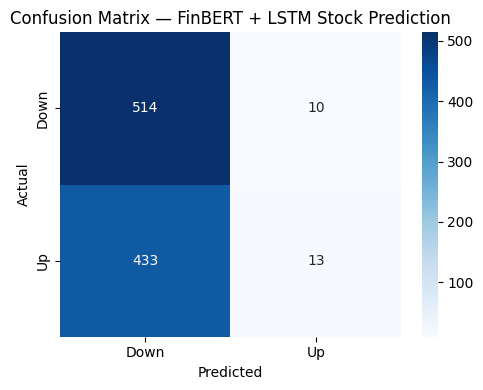

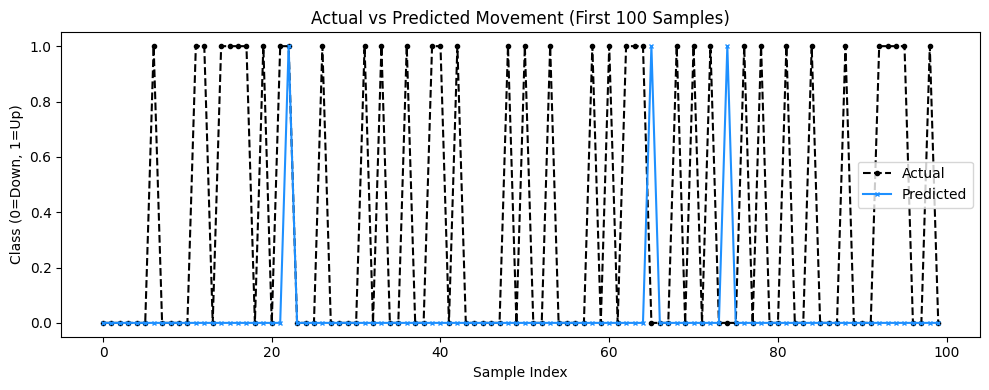

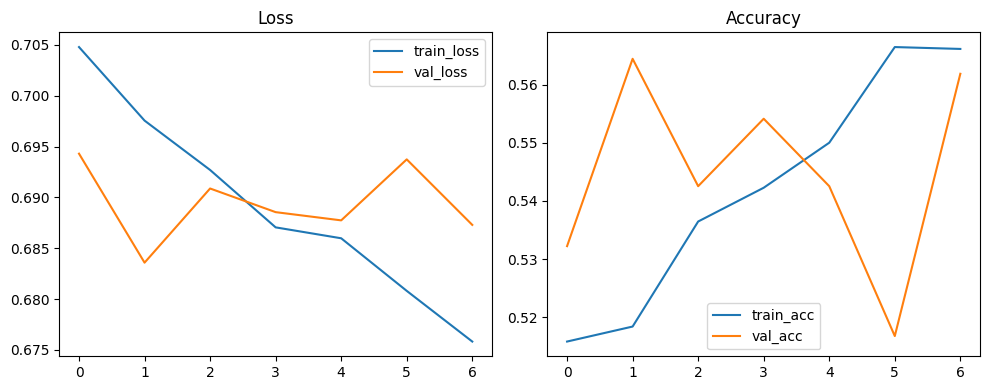


✅ Saved model → 'finbert_lstm_stock_final.h5'
✅ Saved scaler → 'finbert_lstm_stock_scaler.pkl'


In [29]:
# ============================================================
# 7️⃣ Evaluate Model
# ============================================================
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# ============================================================
# 8️⃣ Classification Report & Confusion Matrix
# ============================================================
target_names = ["Down", "Up"]
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix — FinBERT + LSTM Stock Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 9️⃣ Actual vs Predicted (First 100 Samples)
# ============================================================
plt.figure(figsize=(10, 4))
plt.plot(y_test[:100], label="Actual", color="black", linestyle="--", marker="o", markersize=3)
plt.plot(y_pred[:100], label="Predicted", color="dodgerblue", marker="x", markersize=3)
plt.title("Actual vs Predicted Movement (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class (0=Down, 1=Up)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 🔟 Training vs Validation Curves
# ============================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 💾 Save Model, Scaler & Encoder
# ============================================================
model.save("finbert_lstm_stock_final.h5")
joblib.dump(scaler, "finbert_lstm_stock_scaler.pkl")

if le:
    joblib.dump(le, "finbert_lstm_stock_label_encoder.pkl")

print("\n✅ Saved model → 'finbert_lstm_stock_final.h5'")
print("✅ Saved scaler → 'finbert_lstm_stock_scaler.pkl'")
if le:
    print("✅ Saved label encoder → 'finbert_lstm_stock_label_encoder.pkl'")
